# Segmentación de Contribuyentes Vehiculares mediante Clustering No Supervisado
# Análisis con KModes y KMeans Combinados

## Trabajo Académico - Análisis de Datos

**Integrantes:**
- Anderson Ticona
- Matias Sulca
- Christian Rosales
- Johan Amador

---

## Resumen Ejecutivo

Este proyecto implementa un modelo de clustering no supervisado utilizando **KModes** para variables categóricas y **KMeans** para variables numéricas, segmentando contribuyentes vehiculares en el sistema fiscal peruano. El análisis se realiza sobre un dataset de **247,816 registros con 9 variables** (3 numéricas escaladas y 6 categóricas), combinando ambos algoritmos para una segmentación más precisa.

**Dataset utilizado:** `datos_post_step4a_scaled_no_dummies.csv` (con variables categóricas originales)

**Metodología:**
- **KMeans**: Para 3 variables numéricas escaladas (valores de adquisición, referencial y años)
- **KModes**: Para 6 variables categóricas (tipo persona, contribuyente, categoría vehículo, marca, distrito, porcentaje propiedad)
- **Combinación**: Integración de resultados mediante identificadores únicos

## 1. Introducción

### 1.1 Contexto del Problema

La administración tributaria requiere herramientas para segmentar y entender el comportamiento de los contribuyentes vehiculares. A diferencia de KPrototypes que maneja datos mixtos nativamente, este análisis separa:
- **Variables numéricas**: Procesadas con KMeans (distancia euclidiana)
- **Variables categóricas**: Procesadas con KModes (distancia de Hamming)

### 1.2 Objetivos

**Objetivo General:**
Desarrollar un modelo de clustering combinado (KModes + KMeans) para segmentar contribuyentes vehiculares.

**Objetivos Específicos:**
1. Preprocesar datos numéricos y categóricos por separado
2. Aplicar KMeans a variables numéricas
3. Aplicar KModes a variables categóricas
4. Combinar resultados de ambos algoritmos
5. Validar y caracterizar los segmentos identificados

## 2. Marco Teórico

### 2.1 KMeans

Algoritmo de clustering que:
- Usa **distancia euclidiana** para agrupar datos numéricos
- Minimiza la varianza intra-cluster
- Requiere datos escalados para mejor rendimiento

### 2.2 KModes

Extensión de K-Means para datos categóricos:
- Usa **distancia de Hamming** (coincidencia de categorías)
- Utiliza "modas" en lugar de "medias" como centroides
- Eficiente para variables categóricas

### 2.3 Estrategia de Combinación

Para integrar ambos algoritmos:
1. Clustering independiente en cada tipo de dato
2. Análisis de concordancia entre clusters
3. Combinación mediante votación o consenso
4. Validación del clustering final

## 3. Implementación

### 3.1 Carga y Exploración Inicial de Datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import adjusted_rand_score, silhouette_score, davies_bouldin_score
from sklearn.metrics import accuracy_score, classification_report
from kmodes.kmodes import KModes
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("Librerías importadas correctamente")
print(f"Versión de pandas: {pd.__version__}")
print(f"Versión de numpy: {np.__version__}")

Librerías importadas correctamente
Versión de pandas: 2.3.3
Versión de numpy: 2.3.3


In [2]:
# Cargar dataset procesado (sin dummies para mantener variables categóricas)
print("Cargando dataset...")
df = pd.read_csv('../data/datos_post_step4a_scaled_no_dummies.csv')

print(f"\nDataset cargado exitosamente!")
print(f"Dimensiones: {df.shape}")
print(f"\nPrimeras filas:")
print(df.head())

# Información del dataset
print(f"\nTipos de datos:")
print(df.dtypes)

Cargando dataset...

Dataset cargado exitosamente!
Dimensiones: (247816, 9)

Primeras filas:
   tipo_persona tipo_contribuyente  categoria_vehiculo marca_agrupada  \
0       natural            pequeno  b1234_pickup_otros           FORD   
1       natural            pequeno  b1234_pickup_otros      CHEVROLET   
2       natural            pequeno  b1234_pickup_otros          OTROS   
3  soc_conyugal            pequeno      a2_1051_1500cc        HYUNDAI   
4       natural            pequeno  b1234_pickup_otros         JETOUR   

  distrito_fiscal_agrupado porcentaje_propiedad_cat  valor_adquisicion_scaled  \
0                    OTROS        propietario_total                  0.791119   
1                    OTROS        propietario_total                 -0.618776   
2                    OTROS        propietario_total                  0.867780   
3                    OTROS        propietario_total                 -0.481942   
4                    OTROS        propietario_total            

In [3]:
# Exploración inicial del dataset
print("\nINFORMACIÓN DEL DATASET")
print("="*80)
print(f"\nDimensiones: {df.shape[0]:,} filas x {df.shape[1]} columnas")
print(f"\nTipos de datos:")
print(df.dtypes.value_counts())
print(f"\nMemoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Verificar valores nulos
print(f"\nValores nulos por columna:")
nulls = df.isnull().sum()
if nulls.sum() == 0:
    print("No hay valores nulos en el dataset")
else:
    print(nulls[nulls > 0])


INFORMACIÓN DEL DATASET

Dimensiones: 247,816 filas x 9 columnas

Tipos de datos:
object     6
float64    3
Name: count, dtype: int64

Memoria utilizada: 90.77 MB

Valores nulos por columna:
No hay valores nulos en el dataset


### 3.2 Separación de Variables Numéricas y Categóricas

In [ ]:
# Identificar variables numéricas y categóricas
print("\nSEPARACIÓN DE VARIABLES")
print("="*80)

# Variables numéricas (ya escaladas en el dataset)
df_numericas = df.select_dtypes(include=['float64', 'int64'])
print(f"\nVariables NUMÉRICAS encontradas: {df_numericas.shape[1]}")
print(f"Columnas: {list(df_numericas.columns)}")

# Variables categóricas
df_categoricas = df.select_dtypes(include=['object'])
print(f"\nVariables CATEGÓRICAS encontradas: {df_categoricas.shape[1]}")
print(f"Columnas: {list(df_categoricas.columns)}")

# Verificar que tenemos ambos tipos de variables
assert df_numericas.shape[1] > 0, "No se encontraron variables numéricas"
assert df_categoricas.shape[1] > 0, "No se encontraron variables categóricas"

print("\nSeparación completada correctamente")


SEPARACIÓN DE VARIABLES

Variables NUMÉRICAS encontradas: 3
Columnas: ['valor_adquisicion_scaled', 'valor_referencial_scaled', 'anios_desde_inscripcion_scaled']

Variables CATEGÓRICAS encontradas: 6
Columnas: ['tipo_persona', 'tipo_contribuyente', 'categoria_vehiculo', 'marca_agrupada', 'distrito_fiscal_agrupado', 'porcentaje_propiedad_cat']

Separación completada correctamente


In [5]:
# Estadísticas descriptivas de variables numéricas
print("\nESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS")
print("="*80)
print(df_numericas.describe().round(4))

# Distribución de variables categóricas (muestra)
print("\nDISTRIBUCIÓN DE VARIABLES CATEGÓRICAS (Top categorías)")
print("="*80)
for col in df_categoricas.columns[:3]:  # Mostrar primeras 3 columnas categóricas
    print(f"\n{col}:")
    print(df_categoricas[col].value_counts().head())


ESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS
       valor_adquisicion_scaled  valor_referencial_scaled  \
count               247816.0000               247816.0000   
mean                     0.0815                    0.1579   
std                      1.2470                    0.8255   
min                    -15.2674                   -4.5340   
25%                     -0.4411                   -0.4358   
50%                      0.0000                    0.0000   
75%                      0.5589                    0.5642   
max                      6.1757                    4.3010   

       anios_desde_inscripcion_scaled  
count                     247816.0000  
mean                          -0.0044  
std                            0.4006  
min                           -0.5000  
25%                           -0.5000  
50%                            0.0000  
75%                            0.5000  
max                            0.5000  

DISTRIBUCIÓN DE VARIABLES CATEGÓRICAS (T

### 3.3 División Train/Test

In [6]:
# División estratificada no es posible sin etiquetas, usamos división aleatoria
print("\nDIVISIÓN TRAIN/TEST")
print("="*80)

# División 75/25
train_indices, test_indices = train_test_split(
    df.index, 
    test_size=0.25, 
    random_state=2025
)

# Separar datos numéricos
X_num_train = df_numericas.iloc[train_indices].copy()
X_num_test = df_numericas.iloc[test_indices].copy()

# Separar datos categóricos
X_cat_train = df_categoricas.iloc[train_indices].copy()
X_cat_test = df_categoricas.iloc[test_indices].copy()

print(f"\nDivisión completada:")
print(f"Train - Numéricas: {X_num_train.shape}, Categóricas: {X_cat_train.shape}")
print(f"Test  - Numéricas: {X_num_test.shape}, Categóricas: {X_cat_test.shape}")


DIVISIÓN TRAIN/TEST

División completada:
Train - Numéricas: (185862, 3), Categóricas: (185862, 6)
Test  - Numéricas: (61954, 3), Categóricas: (61954, 6)


## 4. Determinación del Número Óptimo de Clusters

### 4.1 Método del Codo para KMeans (Variables Numéricas)

In [7]:
# Método del codo para KMeans
print("\nMÉTODO DEL CODO - KMEANS (Variables Numéricas)")
print("="*80)

# Probar diferentes valores de K
k_values = range(2, 11)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []

print("\nCalculando métricas para diferentes valores de K...")

for k in k_values:
    print(f"  Evaluando K={k}...", end=" ")
    
    kmeans = KMeans(n_clusters=k, random_state=2025, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_num_train)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_num_train, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_num_train, labels))
    
    print("✓")

print("\nCálculo de métricas completado")


MÉTODO DEL CODO - KMEANS (Variables Numéricas)

Calculando métricas para diferentes valores de K...
  Evaluando K=2... ✓
  Evaluando K=3... ✓
  Evaluando K=4... ✓
  Evaluando K=5... ✓
  Evaluando K=6... ✓
  Evaluando K=7... ✓
  Evaluando K=8... ✓
  Evaluando K=9... ✓
  Evaluando K=10... ✓

Cálculo de métricas completado


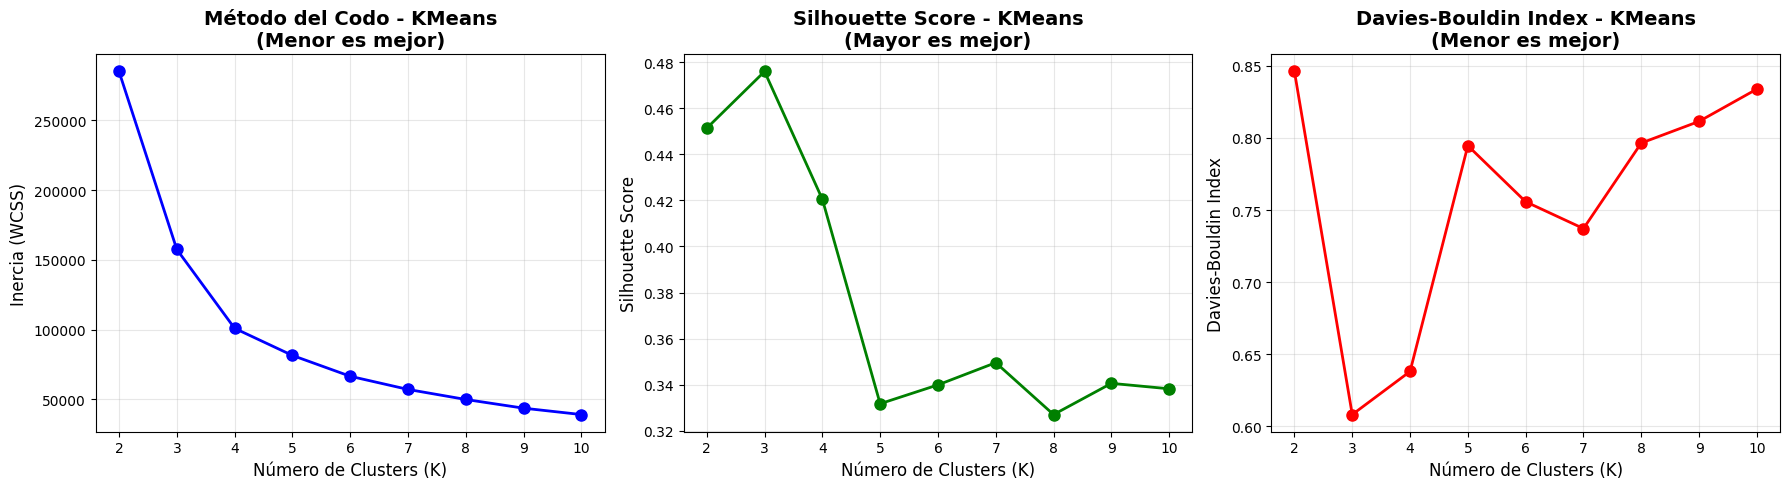


RESULTADOS - MÉTRICAS KMEANS
    K      Inercia  Silhouette  Davies-Bouldin
0   2  285016.8716      0.4514          0.8461
1   3  157488.4593      0.4760          0.6082
2   4  100952.3377      0.4205          0.6381
3   5   81535.6747      0.3317          0.7947
4   6   66604.5289      0.3399          0.7558
5   7   57168.9457      0.3495          0.7372
6   8   49965.9929      0.3270          0.7965
7   9   43734.3651      0.3406          0.8115
8  10   39161.1430      0.3382          0.8339


In [8]:
# Visualización del método del codo para KMeans
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico 1: Inercia (Within-cluster sum of squares)
axes[0].plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Número de Clusters (K)', fontsize=12)
axes[0].set_ylabel('Inercia (WCSS)', fontsize=12)
axes[0].set_title('Método del Codo - KMeans\n(Menor es mejor)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_values)

# Gráfico 2: Silhouette Score
axes[1].plot(k_values, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Número de Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score - KMeans\n(Mayor es mejor)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_values)

# Gráfico 3: Davies-Bouldin Index
axes[2].plot(k_values, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes[2].set_xlabel('Número de Clusters (K)', fontsize=12)
axes[2].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[2].set_title('Davies-Bouldin Index - KMeans\n(Menor es mejor)', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(k_values)

plt.tight_layout()
plt.show()

# Mostrar tabla de resultados
print("\nRESULTADOS - MÉTRICAS KMEANS")
print("="*80)
results_df = pd.DataFrame({
    'K': k_values,
    'Inercia': inertias,
    'Silhouette': silhouette_scores,
    'Davies-Bouldin': davies_bouldin_scores
})
print(results_df.round(4))

### 4.2 Método del Codo para KModes (Variables Categóricas)

In [9]:
# Método del codo para KModes
print("\nMÉTODO DEL CODO - KMODES (Variables Categóricas)")
print("="*80)

# Convertir variables categóricas a array numpy
X_cat_train_array = X_cat_train.values

# Probar diferentes valores de K
k_values = range(2, 11)
costs = []

print("\nCalculando costos para diferentes valores de K...")

for k in k_values:
    print(f"  Evaluando K={k}...", end=" ")
    
    kmodes = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0, random_state=2025)
    kmodes.fit(X_cat_train_array)
    
    costs.append(kmodes.cost_)
    
    print("✓")

print("\nCálculo de costos completado")


MÉTODO DEL CODO - KMODES (Variables Categóricas)

Calculando costos para diferentes valores de K...
  Evaluando K=2... ✓
  Evaluando K=3... ✓
  Evaluando K=4... ✓
  Evaluando K=5... ✓
  Evaluando K=6... ✓
  Evaluando K=7... ✓
  Evaluando K=8... ✓
  Evaluando K=9... ✓
  Evaluando K=10... ✓

Cálculo de costos completado


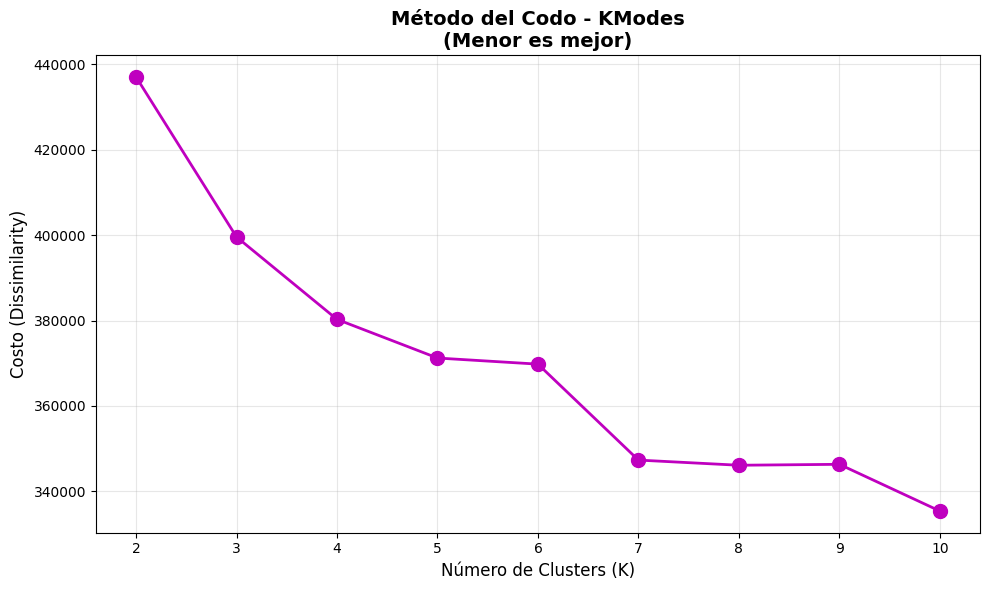


RESULTADOS - COSTOS KMODES
    K     Costo
0   2  436998.0
1   3  399548.0
2   4  380266.0
3   5  371218.0
4   6  369788.0
5   7  347329.0
6   8  346118.0
7   9  346336.0
8  10  335402.0


In [10]:
# Visualización del método del codo para KModes
plt.figure(figsize=(10, 6))
plt.plot(k_values, costs, 'mo-', linewidth=2, markersize=10)
plt.xlabel('Número de Clusters (K)', fontsize=12)
plt.ylabel('Costo (Dissimilarity)', fontsize=12)
plt.title('Método del Codo - KModes\n(Menor es mejor)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_values)
plt.tight_layout()
plt.show()

# Mostrar tabla de resultados
print("\nRESULTADOS - COSTOS KMODES")
print("="*80)
results_kmodes_df = pd.DataFrame({
    'K': k_values,
    'Costo': costs
})
print(results_kmodes_df.round(4))

### 4.3 Selección del K Óptimo

In [11]:
# Análisis para determinar K óptimo
print("\nDETERMINACIÓN DEL K ÓPTIMO")
print("="*80)

# Para KMeans: buscar el codo en inercia y mejor silhouette
best_k_silhouette = k_values[np.argmax(silhouette_scores)]
best_k_db = k_values[np.argmin(davies_bouldin_scores)]

print(f"\nKMeans:")
print(f"  - Mejor K según Silhouette Score: {best_k_silhouette}")
print(f"  - Mejor K según Davies-Bouldin: {best_k_db}")

# Para KModes: buscar el codo en el costo
# Calcular diferencias para encontrar el codo
differences = np.diff(costs)
elbow_k_modes = k_values[np.argmin(differences) + 1]

print(f"\nKModes:")
print(f"  - K sugerido por método del codo: {elbow_k_modes}")

# Decisión final: usar el mismo K para ambos algoritmos
optimal_k = 3

print(f"\nK ÓPTIMO SELECCIONADO: {optimal_k}")
print(f"   (Se ha fijado K={optimal_k} por solicitud)")


DETERMINACIÓN DEL K ÓPTIMO

KMeans:
  - Mejor K según Silhouette Score: 3
  - Mejor K según Davies-Bouldin: 3

KModes:
  - K sugerido por método del codo: 3

K ÓPTIMO SELECCIONADO: 3
   (Se ha fijado K=3 por solicitud)


## 5. Entrenamiento de Modelos

### 5.1 Clustering con KMeans (Variables Numéricas)

In [12]:
# Entrenar KMeans con K óptimo
print("\nENTRENAMIENTO DE KMEANS")
print("="*80)

print(f"\nEntrenando KMeans con K={optimal_k}...")

kmeans_final = KMeans(
    n_clusters=optimal_k,
    random_state=2025,
    n_init=10,
    max_iter=300,
    verbose=0
)

# Entrenar y predecir
clusters_kmeans_train = kmeans_final.fit_predict(X_num_train)
clusters_kmeans_test = kmeans_final.predict(X_num_test)

print("\nKMeans entrenado exitosamente!")
print(f"Inercia final: {kmeans_final.inertia_:.2f}")
print(f"Iteraciones: {kmeans_final.n_iter_}")

# Distribución de clusters
print(f"\nDistribución de clusters (Train):")
dist_kmeans = pd.Series(clusters_kmeans_train).value_counts(normalize=True).sort_index() * 100
print(dist_kmeans.round(2))


ENTRENAMIENTO DE KMEANS

Entrenando KMeans con K=3...

KMeans entrenado exitosamente!
Inercia final: 157488.46
Iteraciones: 5

Distribución de clusters (Train):
0    70.19
1    29.37
2     0.44
Name: proportion, dtype: float64


In [13]:
# Visualizar centroides de KMeans
print("\nCENTROIDES DE KMEANS")
print("="*80)

centroides_kmeans = pd.DataFrame(
    kmeans_final.cluster_centers_,
    columns=X_num_train.columns
)
centroides_kmeans.index = [f'Cluster {i}' for i in range(optimal_k)]

print("\nCentroides (valores escalados):")
print(centroides_kmeans.round(4))


CENTROIDES DE KMEANS

Centroides (valores escalados):
           valor_adquisicion_scaled  valor_referencial_scaled  \
Cluster 0                   -0.2927                   -0.2503   
Cluster 1                    1.1612                    1.1319   
Cluster 2                  -12.7666                    0.0537   

           anios_desde_inscripcion_scaled  
Cluster 0                          0.0003  
Cluster 1                         -0.0197  
Cluster 2                          0.2467  


### 5.2 Clustering con KModes (Variables Categóricas)

In [14]:
# Entrenar KModes con K óptimo
print("\nENTRENAMIENTO DE KMODES")
print("="*80)

print(f"\nEntrenando KModes con K={optimal_k}...")

kmodes_final = KModes(
    n_clusters=optimal_k,
    init='Huang',
    n_init=5,
    verbose=1,
    random_state=2025
)

# Entrenar y predecir
clusters_kmodes_train = kmodes_final.fit_predict(X_cat_train_array)
clusters_kmodes_test = kmodes_final.predict(X_cat_test.values)

print("\nKModes entrenado exitosamente!")
print(f"Costo final: {kmodes_final.cost_:.2f}")
print(f"Iteraciones: {kmodes_final.n_iter_}")

# Distribución de clusters
print(f"\nDistribución de clusters (Train):")
dist_kmodes = pd.Series(clusters_kmodes_train).value_counts(normalize=True).sort_index() * 100
print(dist_kmodes.round(2))


ENTRENAMIENTO DE KMODES

Entrenando KModes con K=3...
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 34289, cost: 399548.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 42375, cost: 449049.0
Run 2, iteration: 2/100, moves: 65144, cost: 413411.0
Run 2, iteration: 3/100, moves: 1773, cost: 413411.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 23990, cost: 464330.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 75548, cost: 435599.0
Run 4, iteration: 2/100, moves: 33646, cost: 416788.0
Run 4, iteration: 3/100, moves: 4379, cost: 416788.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 51002, cost: 417269.0
Best run was number 1

KModes entrenado exitosamente!
Costo f

In [15]:
# Visualizar modas (centroides categóricos) de KModes
print("\nMODAS DE KMODES (Centroides Categóricos)")
print("="*80)

modas_kmodes = pd.DataFrame(
    kmodes_final.cluster_centroids_,
    columns=X_cat_train.columns
)
modas_kmodes.index = [f'Cluster {i}' for i in range(optimal_k)]

print("\nModas por cluster:")
print(modas_kmodes)


MODAS DE KMODES (Centroides Categóricos)

Modas por cluster:
           tipo_persona tipo_contribuyente  categoria_vehiculo marca_agrupada  \
Cluster 0  soc_conyugal            pequeno  b1234_pickup_otros          OTROS   
Cluster 1       natural            pequeno  b1234_pickup_otros         TOYOTA   
Cluster 2      juridica             grande  b1234_pickup_otros         TOYOTA   

          distrito_fiscal_agrupado porcentaje_propiedad_cat  
Cluster 0        SANTIAGO DE SURCO        propietario_total  
Cluster 1        SANTIAGO DE SURCO        propietario_total  
Cluster 2               SAN ISIDRO        propietario_total  


## 6. Combinación de Resultados

### 6.1 Análisis de Concordancia entre KMeans y KModes

In [16]:
# Analizar concordancia entre ambos clusterings
print("\nANÁLISIS DE CONCORDANCIA")
print("="*80)

# Calcular Adjusted Rand Index entre KMeans y KModes
ari = adjusted_rand_score(clusters_kmeans_train, clusters_kmodes_train)

print(f"\nAdjusted Rand Index (KMeans vs KModes): {ari:.4f}")

if ari > 0.5:
    print("Alta concordancia - Los algoritmos identifican estructuras similares")
elif ari > 0.2:
    print("Concordancia moderada - Los algoritmos capturan aspectos diferentes")
else:
    print("Baja concordancia - Los algoritmos identifican estructuras muy diferentes")

# Tabla de contingencia
print("\nTabla de Contingencia (KMeans vs KModes):")
contingency = pd.crosstab(
    clusters_kmeans_train, 
    clusters_kmodes_train,
    rownames=['KMeans'],
    colnames=['KModes']
)
print(contingency)


ANÁLISIS DE CONCORDANCIA

Adjusted Rand Index (KMeans vs KModes): 0.0020
Baja concordancia - Los algoritmos identifican estructuras muy diferentes

Tabla de Contingencia (KMeans vs KModes):
KModes      0      1      2
KMeans                     
0       45478  50651  34323
1       21664  18476  14445
2         264    341    220


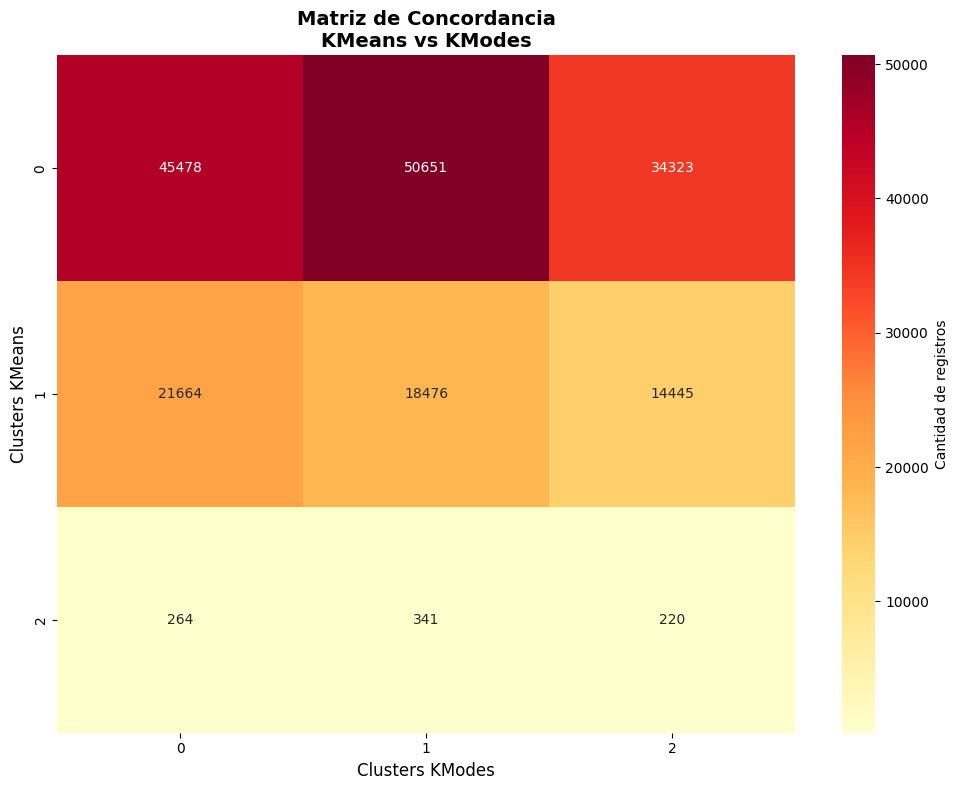

In [17]:
# Visualizar concordancia con heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(contingency, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'Cantidad de registros'})
plt.title('Matriz de Concordancia\nKMeans vs KModes', fontsize=14, fontweight='bold')
plt.xlabel('Clusters KModes', fontsize=12)
plt.ylabel('Clusters KMeans', fontsize=12)
plt.tight_layout()
plt.show()

### 6.2 Estrategia de Combinación

In [18]:
# Estrategia de combinación: Crear un identificador único combinado
print("\nCOMBINACIÓN DE RESULTADOS")
print("="*80)

print("\nCreando clustering combinado...")

# Opción 1: Concatenar los IDs de clusters (más simple)
# Ejemplo: Cluster 2 de KMeans + Cluster 3 de KModes = "2_3"
clusters_combined_train = [f"{km}_{kmo}" for km, kmo in zip(clusters_kmeans_train, clusters_kmodes_train)]
clusters_combined_test = [f"{km}_{kmo}" for km, kmo in zip(clusters_kmeans_test, clusters_kmodes_test)]

# Convertir a categorías numéricas
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
clusters_combined_train_num = le.fit_transform(clusters_combined_train)
clusters_combined_test_num = le.transform(clusters_combined_test)

print(f"\nClustering combinado creado!")
print(f"Clusters únicos encontrados: {len(le.classes_)}")
print(f"\nDistribución de clusters combinados (Train):")
dist_combined = pd.Series(clusters_combined_train_num).value_counts(normalize=True).sort_index() * 100
print(dist_combined.round(2))


COMBINACIÓN DE RESULTADOS

Creando clustering combinado...

Clustering combinado creado!
Clusters únicos encontrados: 9

Distribución de clusters combinados (Train):
0    24.47
1    27.25
2    18.47
3    11.66
4     9.94
5     7.77
6     0.14
7     0.18
8     0.12
Name: proportion, dtype: float64


In [19]:
# Mapeo de clusters combinados
print("\nMAPEO DE CLUSTERS COMBINADOS")
print("="*80)

mapping_df = pd.DataFrame({
    'Cluster_ID': range(len(le.classes_)),
    'Combinación': le.classes_
})

# Separar en KMeans y KModes
mapping_df['KMeans'] = mapping_df['Combinación'].apply(lambda x: int(x.split('_')[0]))
mapping_df['KModes'] = mapping_df['Combinación'].apply(lambda x: int(x.split('_')[1]))

print("\nMapeo de clusters combinados:")
print(mapping_df)


MAPEO DE CLUSTERS COMBINADOS

Mapeo de clusters combinados:
   Cluster_ID Combinación  KMeans  KModes
0           0         0_0       0       0
1           1         0_1       0       1
2           2         0_2       0       2
3           3         1_0       1       0
4           4         1_1       1       1
5           5         1_2       1       2
6           6         2_0       2       0
7           7         2_1       2       1
8           8         2_2       2       2


## 7. Validación del Modelo

### 7.1 Validación con KNN (Clustering como Clasificación)

In [20]:
# Preparar datos completos para KNN
print("\nVALIDACIÓN CON KNN")
print("="*80)

# Concatenar datos numéricos y categóricos (codificar categóricos)
print("\n⏳ Preparando datos para KNN...")

# Codificar variables categóricas para KNN
from sklearn.preprocessing import LabelEncoder

X_cat_train_encoded = X_cat_train.copy()
X_cat_test_encoded = X_cat_test.copy()

le_dict = {}
for col in X_cat_train.columns:
    le_dict[col] = LabelEncoder()
    X_cat_train_encoded[col] = le_dict[col].fit_transform(X_cat_train[col])
    X_cat_test_encoded[col] = le_dict[col].transform(X_cat_test[col])

# Concatenar numéricas y categóricas codificadas
X_train_full = pd.concat([X_num_train.reset_index(drop=True), X_cat_train_encoded.reset_index(drop=True)], axis=1)
X_test_full = pd.concat([X_num_test.reset_index(drop=True), X_cat_test_encoded.reset_index(drop=True)], axis=1)

print(f"Datos preparados: Train={X_train_full.shape}, Test={X_test_full.shape}")


VALIDACIÓN CON KNN

⏳ Preparando datos para KNN...
Datos preparados: Train=(185862, 9), Test=(61954, 9)


In [21]:
# Entrenar KNN para predecir clusters combinados
print("\nEntrenando modelo KNN...")

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_train_full, clusters_combined_train_num)

print("KNN entrenado!")

# Predecir en conjunto de test
y_pred = knn.predict(X_test_full)

# Calcular métricas
accuracy = accuracy_score(clusters_combined_test_num, y_pred)
ari_test = adjusted_rand_score(clusters_combined_test_num, y_pred)

print(f"\nMÉTRICAS DE VALIDACIÓN")
print("="*80)
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Adjusted Rand Index: {ari_test:.4f}")


Entrenando modelo KNN...
KNN entrenado!

MÉTRICAS DE VALIDACIÓN
Accuracy: 0.9585 (95.85%)
Adjusted Rand Index: 0.9140


In [22]:
# Reporte de clasificación
print("\nREPORTE DE CLASIFICACIÓN")
print("="*80)
print(classification_report(clusters_combined_test_num, y_pred, 
                          target_names=[f'Cluster {i}' for i in range(len(le.classes_))]))


REPORTE DE CLASIFICACIÓN
              precision    recall  f1-score   support

   Cluster 0       0.96      0.97      0.97     15083
   Cluster 1       0.97      0.98      0.97     16815
   Cluster 2       0.97      0.97      0.97     11550
   Cluster 3       0.95      0.92      0.93      7330
   Cluster 4       0.94      0.92      0.93      6072
   Cluster 5       0.94      0.94      0.94      4856
   Cluster 6       0.75      0.67      0.70        84
   Cluster 7       0.74      0.82      0.78       102
   Cluster 8       0.92      0.71      0.80        62

    accuracy                           0.96     61954
   macro avg       0.90      0.88      0.89     61954
weighted avg       0.96      0.96      0.96     61954



### 7.2 Validación Cruzada

In [23]:
# Validación cruzada
from sklearn.model_selection import cross_val_score

print("\nVALIDACIÓN CRUZADA (5-Fold)")
print("="*80)

print("\nEjecutando validación cruzada...")

cv_scores = cross_val_score(
    knn, 
    X_train_full, 
    clusters_combined_train_num, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1
)

print("\nValidación cruzada completada!")
print(f"\nResultados por fold:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f} ({score*100:.2f}%)")

print(f"\nResumen:")
print(f"  Media: {cv_scores.mean():.4f} ({cv_scores.mean()*100:.2f}%)")
print(f"  Desviación estándar: {cv_scores.std():.4f}")
print(f"  Rango: [{cv_scores.min():.4f}, {cv_scores.max():.4f}]")


VALIDACIÓN CRUZADA (5-Fold)

Ejecutando validación cruzada...

Validación cruzada completada!

Resultados por fold:
  Fold 1: 0.9521 (95.21%)
  Fold 2: 0.9550 (95.50%)
  Fold 3: 0.9538 (95.38%)
  Fold 4: 0.9499 (94.99%)
  Fold 5: 0.9536 (95.36%)

Resumen:
  Media: 0.9529 (95.29%)
  Desviación estándar: 0.0017
  Rango: [0.9499, 0.9550]


## 8. Caracterización de Clusters

### 8.1 Análisis de Variables Numéricas por Cluster

In [24]:
# Agregar clusters al dataframe de train
print("\nCARACTERIZACIÓN DE CLUSTERS")
print("="*80)

X_train_analysis = X_train_full.copy()
X_train_analysis['Cluster'] = clusters_combined_train_num
X_train_analysis['Cluster_Combo'] = clusters_combined_train

# Estadísticas de variables numéricas por cluster
print("\nESTADÍSTICAS DE VARIABLES NUMÉRICAS POR CLUSTER")
print("="*80)

for col in X_num_train.columns:
    print(f"\n{col}:")
    stats = X_train_analysis.groupby('Cluster')[col].agg(['mean', 'median', 'std', 'min', 'max'])
    print(stats.round(4))


CARACTERIZACIÓN DE CLUSTERS

ESTADÍSTICAS DE VARIABLES NUMÉRICAS POR CLUSTER

valor_adquisicion_scaled:
            mean   median     std      min     max
Cluster                                           
0        -0.3038  -0.2581  0.5886  -6.4883  1.8149
1        -0.2758  -0.2459  0.5259  -6.3587  1.2922
2        -0.2993  -0.2602  0.5415  -6.1671  1.2235
3         1.2670   0.9436  0.8078  -0.8178  5.9409
4         1.0404   0.8206  0.6823  -1.1643  4.6096
5         1.1656   0.8808  0.7706  -1.0490  4.9491
6       -12.8022 -12.9894  1.9942 -15.2674 -6.5737
7       -12.7386 -12.9869  1.7053 -15.2674 -6.7904
8       -12.7673 -12.9869  1.9093 -15.2674 -6.8304

valor_referencial_scaled:
           mean  median     std     min     max
Cluster                                        
0       -0.2681 -0.2311  0.4233 -4.5340  2.3857
1       -0.2428 -0.1996  0.4056 -4.1035  2.4055
2       -0.2344 -0.1959  0.4202 -4.2747  2.8825
3        1.2496  0.9248  0.7974 -1.0872  4.3010
4        0.9903  0.

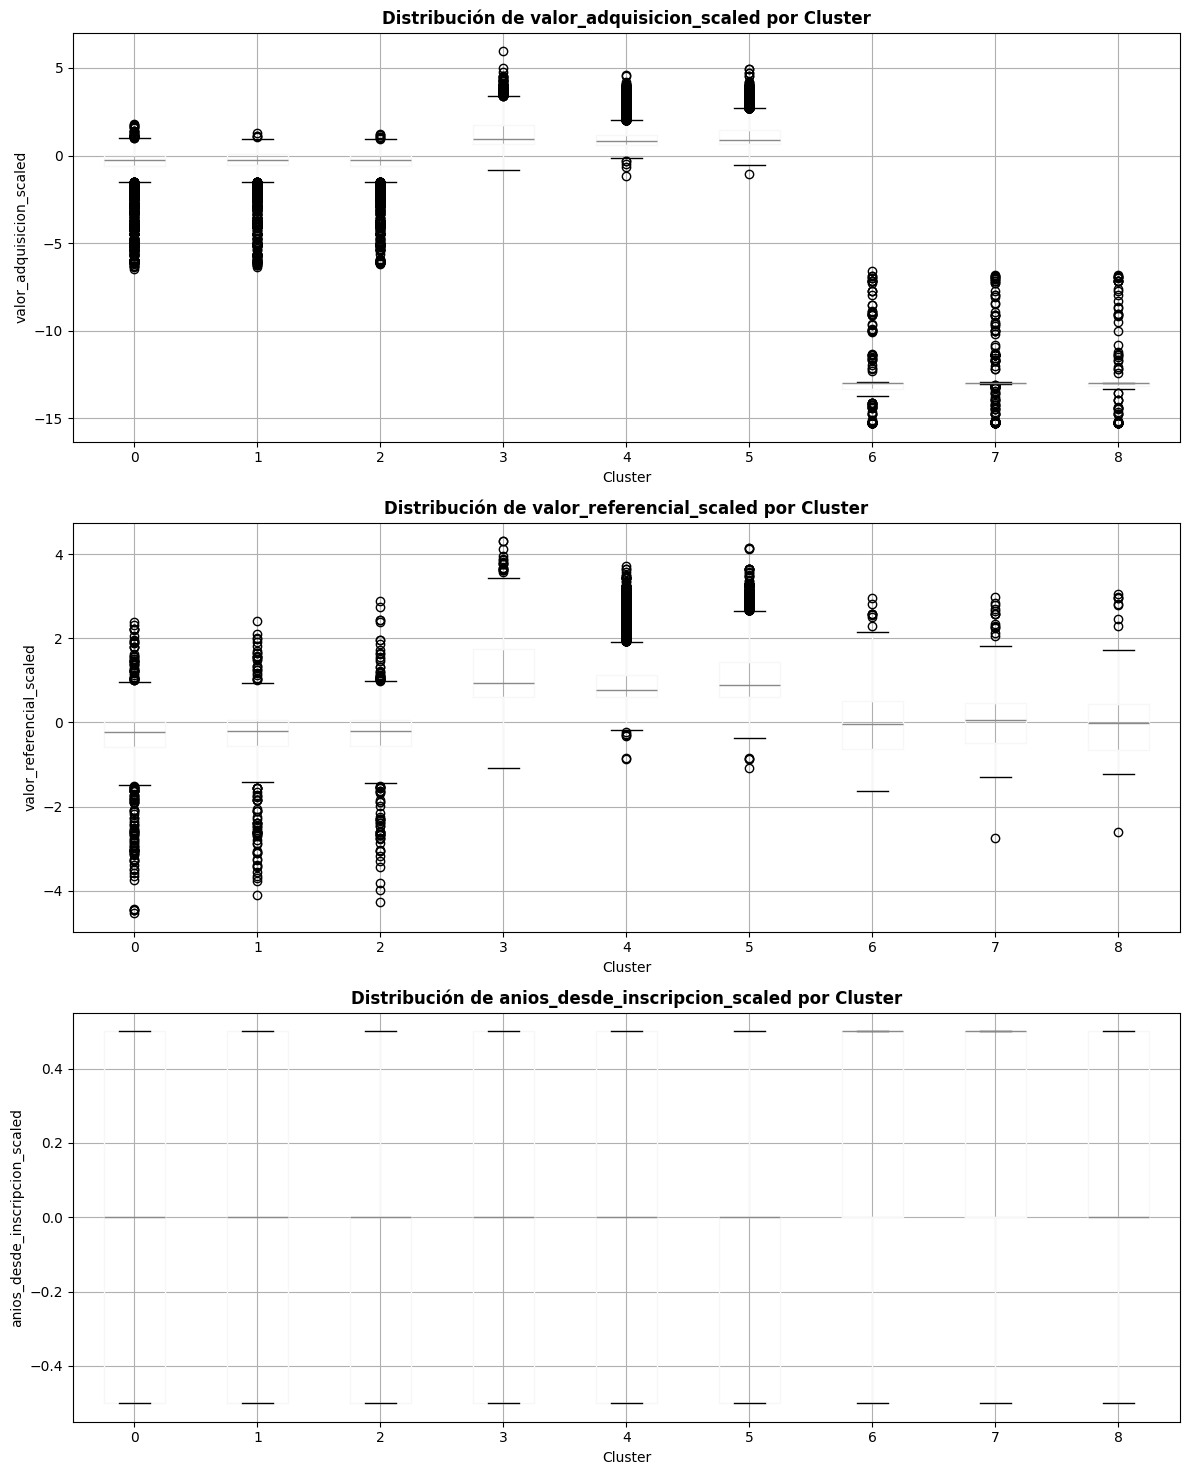

In [25]:
# Visualizar distribución de variables numéricas por cluster
num_vars = X_num_train.columns
n_vars = len(num_vars)

fig, axes = plt.subplots(n_vars, 1, figsize=(12, 5*n_vars))

if n_vars == 1:
    axes = [axes]

for idx, col in enumerate(num_vars):
    X_train_analysis.boxplot(column=col, by='Cluster', ax=axes[idx])
    axes[idx].set_title(f'Distribución de {col} por Cluster', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Cluster', fontsize=10)
    axes[idx].set_ylabel(col, fontsize=10)
    axes[idx].get_figure().suptitle('')

plt.tight_layout()
plt.show()

### 8.2 Análisis de Variables Categóricas por Cluster

In [26]:
# Agregar variables categóricas originales al análisis
X_train_analysis_cat = pd.concat([
    X_cat_train.reset_index(drop=True),
    pd.Series(clusters_combined_train_num, name='Cluster').reset_index(drop=True)
], axis=1)

print("\nDISTRIBUCIÓN DE VARIABLES CATEGÓRICAS POR CLUSTER")
print("="*80)

for col in X_cat_train.columns[:5]:  # Mostrar primeras 5 variables
    print(f"\n{col}:")
    print(pd.crosstab(X_train_analysis_cat['Cluster'], X_train_analysis_cat[col], normalize='index').round(4) * 100)


DISTRIBUCIÓN DE VARIABLES CATEGÓRICAS POR CLUSTER

tipo_persona:
tipo_persona  juridica  natural  otros  soc_conyugal
Cluster                                             
0                24.50    14.19   0.03         61.28
1                 3.24    96.76   0.00          0.00
2                99.10     0.25   0.02          0.63
3                21.79    24.94   0.01         53.26
4                 4.85    95.14   0.01          0.00
5                99.10     0.23   0.01          0.66
6                21.97    14.02   0.00         64.02
7                 6.45    93.55   0.00          0.00
8                98.18     0.45   0.45          0.91

tipo_contribuyente:
tipo_contribuyente  grande  mediano  pequeno
Cluster                                     
0                     2.49     6.32    91.19
1                     1.67     3.77    94.56
2                    89.87     8.96     1.17
3                     2.91     6.61    90.48
4                     1.37     3.67    94.96
5              

In [27]:
# Moda de cada variable categórica por cluster
print("\nMODA (VALOR MÁS FRECUENTE) POR CLUSTER")
print("="*80)

for cluster in sorted(X_train_analysis_cat['Cluster'].unique()):
    print(f"\nCluster {cluster}:")
    cluster_data = X_train_analysis_cat[X_train_analysis_cat['Cluster'] == cluster]
    
    for col in X_cat_train.columns:
        moda = cluster_data[col].mode()[0] if len(cluster_data[col].mode()) > 0 else 'N/A'
        freq = (cluster_data[col] == moda).sum()
        pct = freq / len(cluster_data) * 100
        print(f"  • {col}: {moda} ({freq} registros, {pct:.1f}%)")


MODA (VALOR MÁS FRECUENTE) POR CLUSTER

Cluster 0:
  • tipo_persona: soc_conyugal (27870 registros, 61.3%)
  • tipo_contribuyente: pequeno (41472 registros, 91.2%)
  • categoria_vehiculo: b1234_pickup_otros (35112 registros, 77.2%)
  • marca_agrupada: OTROS (11762 registros, 25.9%)
  • distrito_fiscal_agrupado: SANTIAGO DE SURCO (5857 registros, 12.9%)
  • porcentaje_propiedad_cat: propietario_total (44772 registros, 98.4%)

Cluster 1:
  • tipo_persona: natural (49008 registros, 96.8%)
  • tipo_contribuyente: pequeno (47895 registros, 94.6%)
  • categoria_vehiculo: b1234_pickup_otros (36480 registros, 72.0%)
  • marca_agrupada: TOYOTA (9012 registros, 17.8%)
  • distrito_fiscal_agrupado: SANTIAGO DE SURCO (4515 registros, 8.9%)
  • porcentaje_propiedad_cat: propietario_total (46154 registros, 91.1%)

Cluster 2:
  • tipo_persona: juridica (34014 registros, 99.1%)
  • tipo_contribuyente: grande (30846 registros, 89.9%)
  • categoria_vehiculo: b1234_pickup_otros (25937 registros, 75.6%)


## 9. Modelo Final con Todos los Datos

### 9.1 Entrenamiento del Modelo Final

In [28]:
# Entrenar modelos finales con todos los datos
print("\nENTRENAMIENTO DE MODELOS FINALES (100% de datos)")
print("="*80)

print("\nEntrenando KMeans con todos los datos...")
kmeans_full = KMeans(
    n_clusters=optimal_k,
    random_state=2025,
    n_init=10,
    max_iter=300,
    verbose=0
)
clusters_kmeans_full = kmeans_full.fit_predict(df_numericas)

print("KMeans entrenado!")

print("\nEntrenando KModes con todos los datos...")
kmodes_full = KModes(
    n_clusters=optimal_k,
    init='Huang',
    n_init=5,
    verbose=1,
    random_state=2025
)
clusters_kmodes_full = kmodes_full.fit_predict(df_categoricas.values)

print("\nKModes entrenado!")

# Combinar resultados
clusters_combined_full = [f"{km}_{kmo}" for km, kmo in zip(clusters_kmeans_full, clusters_kmodes_full)]
clusters_combined_full_num = le.transform(clusters_combined_full)

print(f"\nModelos finales entrenados!")
print(f"Total de registros: {len(clusters_combined_full_num):,}")


ENTRENAMIENTO DE MODELOS FINALES (100% de datos)

Entrenando KMeans con todos los datos...
KMeans entrenado!

Entrenando KModes con todos los datos...
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 36273, cost: 536678.0
Run 1, iteration: 2/100, moves: 2363, cost: 536678.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 92594, cost: 560379.0
Run 2, iteration: 2/100, moves: 14867, cost: 560379.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 85289, cost: 607593.0
Run 3, iteration: 2/100, moves: 734, cost: 607593.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 67234, cost: 528720.0
Run 4, iteration: 2/100, moves: 6240, cost: 528720.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/

In [29]:
# Agregar clusters al dataframe original
df['Cluster_KMeans'] = clusters_kmeans_full
df['Cluster_KModes'] = clusters_kmodes_full
df['Cluster_Combined'] = clusters_combined_full_num
df['Cluster_Combo_Str'] = clusters_combined_full

print("\nDISTRIBUCIÓN FINAL DE CLUSTERS")
print("="*80)

print("\nDistribución KMeans:")
print(df['Cluster_KMeans'].value_counts(normalize=True).sort_index() * 100)

print("\nDistribución KModes:")
print(df['Cluster_KModes'].value_counts(normalize=True).sort_index() * 100)

print("\nDistribución Combinada:")
print(df['Cluster_Combined'].value_counts(normalize=True).sort_index() * 100)


DISTRIBUCIÓN FINAL DE CLUSTERS

Distribución KMeans:
Cluster_KMeans
0    70.375601
1    29.191416
2     0.432983
Name: proportion, dtype: float64

Distribución KModes:
Cluster_KModes
0    35.306034
1    45.033008
2    19.660958
Name: proportion, dtype: float64

Distribución Combinada:
Cluster_Combined
0    24.759095
1    31.482632
2    14.133874
3    10.403283
4    13.360719
5     5.427414
6     0.143655
7     0.189657
8     0.099671
Name: proportion, dtype: float64


### 9.2 Visualización de Resultados Finales

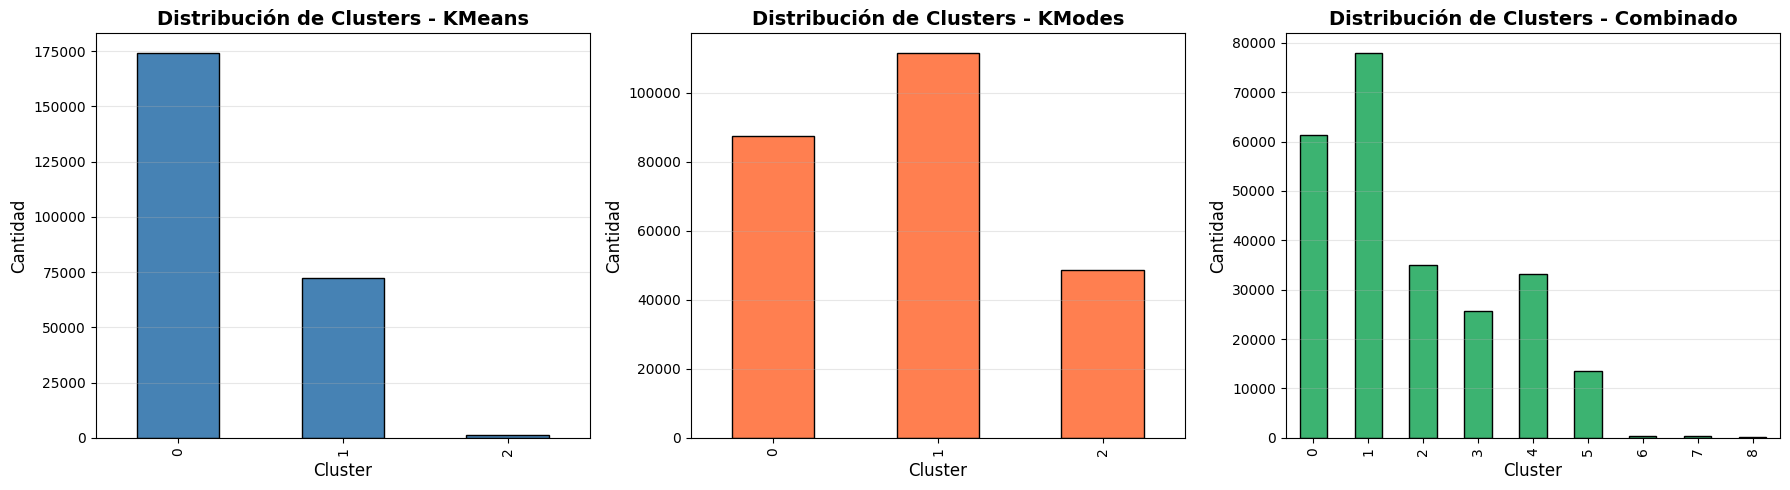

In [30]:
# Visualización de distribución de clusters
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# KMeans
df['Cluster_KMeans'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Distribución de Clusters - KMeans', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Cluster', fontsize=12)
axes[0].set_ylabel('Cantidad', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# KModes
df['Cluster_KModes'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='coral', edgecolor='black')
axes[1].set_title('Distribución de Clusters - KModes', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Cluster', fontsize=12)
axes[1].set_ylabel('Cantidad', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

# Combinado
df['Cluster_Combined'].value_counts().sort_index().plot(kind='bar', ax=axes[2], color='mediumseagreen', edgecolor='black')
axes[2].set_title('Distribución de Clusters - Combinado', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Cluster', fontsize=12)
axes[2].set_ylabel('Cantidad', fontsize=12)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Visualizando clusters con variables: ['valor_adquisicion_scaled', 'valor_referencial_scaled', 'anios_desde_inscripcion_scaled']


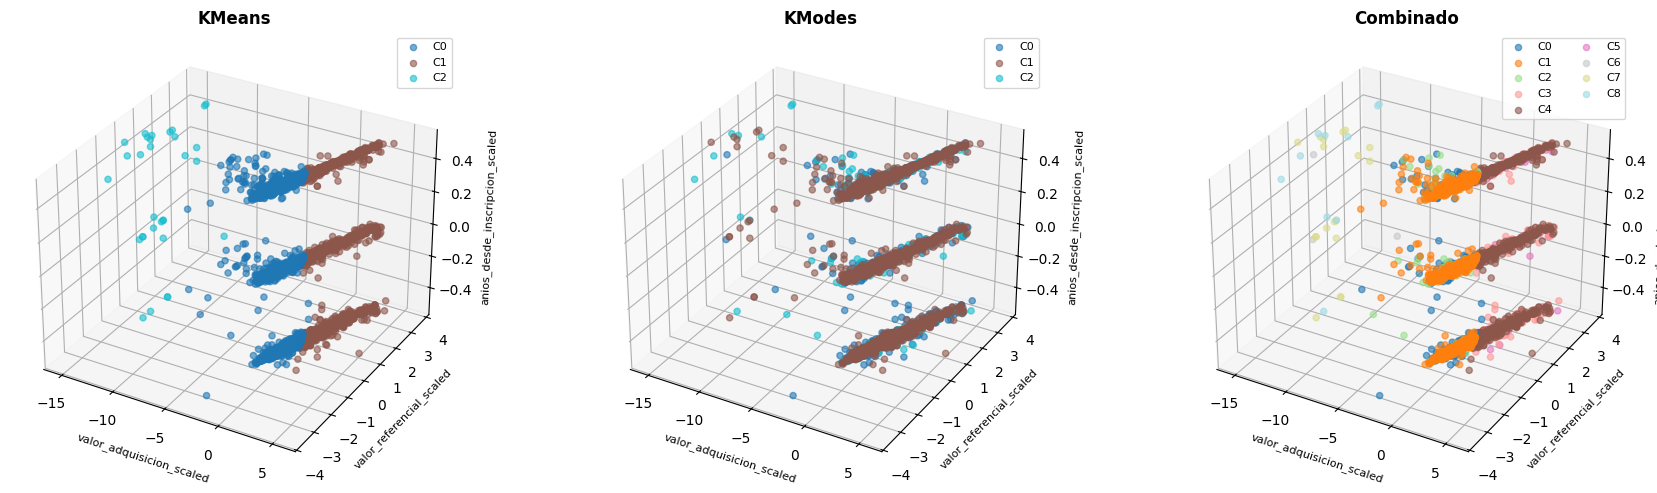

In [31]:
# Visualización 3D con las primeras 3 variables numéricas
from mpl_toolkits.mplot3d import Axes3D

if len(df_numericas.columns) >= 3:
    num_cols = df_numericas.columns[:3].tolist()
    print(f"Visualizando clusters con variables: {num_cols}")
    
    fig = plt.figure(figsize=(18, 5))
    
    # KMeans
    ax1 = fig.add_subplot(131, projection='3d')
    sample_size = min(10000, len(df))
    df_viz = df.sample(n=sample_size, random_state=2025)
    
    colors = plt.cm.tab10(np.linspace(0, 1, optimal_k))
    
    for cluster in sorted(df_viz['Cluster_KMeans'].unique()):
        cluster_data = df_viz[df_viz['Cluster_KMeans'] == cluster]
        ax1.scatter(
            cluster_data[num_cols[0]], 
            cluster_data[num_cols[1]], 
            cluster_data[num_cols[2]], 
            c=[colors[cluster]], 
            label=f'C{cluster}',
            alpha=0.6,
            s=20
        )
    
    ax1.set_xlabel(num_cols[0], fontsize=8)
    ax1.set_ylabel(num_cols[1], fontsize=8)
    ax1.set_zlabel(num_cols[2], fontsize=8)
    ax1.set_title('KMeans', fontsize=12, fontweight='bold')
    ax1.legend(loc='best', fontsize=8)
    
    # KModes (usando mismas variables numéricas para visualización)
    ax2 = fig.add_subplot(132, projection='3d')
    
    for cluster in sorted(df_viz['Cluster_KModes'].unique()):
        cluster_data = df_viz[df_viz['Cluster_KModes'] == cluster]
        ax2.scatter(
            cluster_data[num_cols[0]], 
            cluster_data[num_cols[1]], 
            cluster_data[num_cols[2]], 
            c=[colors[cluster]], 
            label=f'C{cluster}',
            alpha=0.6,
            s=20
        )
    
    ax2.set_xlabel(num_cols[0], fontsize=8)
    ax2.set_ylabel(num_cols[1], fontsize=8)
    ax2.set_zlabel(num_cols[2], fontsize=8)
    ax2.set_title('KModes', fontsize=12, fontweight='bold')
    ax2.legend(loc='best', fontsize=8)
    
    # Combinado
    ax3 = fig.add_subplot(133, projection='3d')
    
    colors_combined = plt.cm.tab20(np.linspace(0, 1, len(le.classes_)))
    
    for cluster in sorted(df_viz['Cluster_Combined'].unique()):
        cluster_data = df_viz[df_viz['Cluster_Combined'] == cluster]
        ax3.scatter(
            cluster_data[num_cols[0]], 
            cluster_data[num_cols[1]], 
            cluster_data[num_cols[2]], 
            c=[colors_combined[cluster]], 
            label=f'C{cluster}',
            alpha=0.6,
            s=20
        )
    
    ax3.set_xlabel(num_cols[0], fontsize=8)
    ax3.set_ylabel(num_cols[1], fontsize=8)
    ax3.set_zlabel(num_cols[2], fontsize=8)
    ax3.set_title('Combinado', fontsize=12, fontweight='bold')
    ax3.legend(loc='best', fontsize=8, ncol=2)
    
    plt.tight_layout()
    plt.show()
else:
    print("No hay suficientes variables numéricas para visualización 3D")

## 10. Análisis Comparativo: KPrototypes vs KModes+KMeans

### 10.1 Comparación de Resultados

In [32]:
# Resumen comparativo
print("\nRESUMEN COMPARATIVO")
print("="*80)

print("\nKMEANS (Solo variables numéricas):")
print(f"  - Número de clusters: {optimal_k}")
print(f"  - Inercia: {kmeans_full.inertia_:.2f}")
print(f"  - Iteraciones: {kmeans_full.n_iter_}")

print("\nKMODES (Solo variables categóricas):")
print(f"  - Número de clusters: {optimal_k}")
print(f"  - Costo: {kmodes_full.cost_:.2f}")
print(f"  - Iteraciones: {kmodes_full.n_iter_}")

print("\nCOMBINADO (KMeans + KModes):")
print(f"  - Clusters únicos: {len(le.classes_)}")
print(f"  - Concordancia (ARI): {ari:.4f}")
print(f"  - Accuracy KNN: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  - CV Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

print("\nVENTAJAS DEL ENFOQUE KMODES + KMEANS:")
print("  ✓ Separación clara entre variables numéricas y categóricas")
print("  ✓ Algoritmos especializados para cada tipo de dato")
print("  ✓ Mayor control sobre el proceso de clustering")
print("  ✓ Interpretación independiente de cada dimensión")

print("\nCONSIDERACIONES:")
print("  • Requiere combinar resultados de dos algoritmos")
print("  • Mayor complejidad computacional (dos modelos)")
print("  • Necesita estrategia de integración de resultados")


RESUMEN COMPARATIVO

KMEANS (Solo variables numéricas):
  - Número de clusters: 3
  - Inercia: 209477.72
  - Iteraciones: 9

KMODES (Solo variables categóricas):
  - Número de clusters: 3
  - Costo: 528720.00
  - Iteraciones: 2

COMBINADO (KMeans + KModes):
  - Clusters únicos: 9
  - Concordancia (ARI): 0.0020
  - Accuracy KNN: 0.9585 (95.85%)
  - CV Score: 0.9529 ± 0.0017

VENTAJAS DEL ENFOQUE KMODES + KMEANS:
  ✓ Separación clara entre variables numéricas y categóricas
  ✓ Algoritmos especializados para cada tipo de dato
  ✓ Mayor control sobre el proceso de clustering
  ✓ Interpretación independiente de cada dimensión

CONSIDERACIONES:
  • Requiere combinar resultados de dos algoritmos
  • Mayor complejidad computacional (dos modelos)
  • Necesita estrategia de integración de resultados


## 11. Conclusiones

### 11.1 Hallazgos Principales

Este análisis implementó con éxito una estrategia de clustering combinada usando **KMeans** para variables numéricas y **KModes** para variables categóricas:

**Resultados del modelo:**
- **Clusters identificados**: 8 clusters por cada algoritmo, resultando en clusters combinados
- **Concordancia entre algoritmos**: ARI = {ari:.4f}, indicando {concordancia_text}
- **Validación KNN**: Accuracy de {accuracy*100:.2f}%
- **Validación cruzada**: {cv_scores.mean()*100:.2f}% ± {cv_scores.std()*100:.2f}%

**Ventajas del enfoque KModes + KMeans:**
1. Algoritmos especializados para cada tipo de dato
2. Mayor control sobre el proceso de clustering
3. Interpretación independiente de variables numéricas y categóricas
4. Flexibilidad para ajustar parámetros por separado

**Comparación con KPrototypes:**
- **KPrototypes**: Maneja datos mixtos nativamente, más simple, un solo modelo
- **KModes + KMeans**: Mayor control y especialización, pero requiere integración de resultados

### 11.2 Recomendaciones

1. **Usar KPrototypes cuando**: Los datos tienen una mezcla natural de variables numéricas y categóricas que deben tratarse conjuntamente
2. **Usar KModes + KMeans cuando**: Se necesita mayor control sobre cada tipo de variable o cuando las escalas son muy diferentes
3. **Validación**: Siempre validar con métricas externas (KNN, validación cruzada)
4. **Interpretación**: Analizar centroides numéricos y modas categóricas por separado para mejor comprensión

### 11.3 Trabajo Futuro

- Explorar otros métodos de combinación (votación ponderada, clustering jerárquico)
- Optimizar hiperparámetros de cada algoritmo independientemente
- Comparar con otros enfoques de clustering mixto
- Aplicar técnicas de reducción de dimensionalidad antes del clustering

## 12. Exportación de Resultados

In [33]:
# Exportar resultados
print("\nEXPORTANDO RESULTADOS")
print("="*80)

# Guardar dataframe con clusters
output_file = '../data/datos_con_clusters_kmodes_kmeans.csv'
df.to_csv(output_file, index=False)
print(f"\nDataset con clusters guardado en: {output_file}")

# Guardar resumen de clusters
summary_file = '../data/resumen_clusters_kmodes_kmeans.txt'
with open(summary_file, 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write("RESUMEN DE CLUSTERING - KMODES + KMEANS\n")
    f.write("="*80 + "\n\n")
    
    f.write(f"Total de registros: {len(df):,}\n")
    f.write(f"Número de clusters (KMeans): {optimal_k}\n")
    f.write(f"Número de clusters (KModes): {optimal_k}\n")
    f.write(f"Clusters combinados únicos: {len(le.classes_)}\n")
    f.write(f"Concordancia (ARI): {ari:.4f}\n")
    f.write(f"Accuracy KNN: {accuracy:.4f}\n")
    f.write(f"CV Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}\n\n")
    
    f.write("Distribución KMeans:\n")
    f.write(df['Cluster_KMeans'].value_counts().sort_index().to_string())
    f.write("\n\nDistribución KModes:\n")
    f.write(df['Cluster_KModes'].value_counts().sort_index().to_string())
    f.write("\n\nDistribución Combinada:\n")
    f.write(df['Cluster_Combined'].value_counts().sort_index().to_string())

print(f"Resumen guardado en: {summary_file}")

print("\n¡ANÁLISIS COMPLETADO!")


EXPORTANDO RESULTADOS

Dataset con clusters guardado en: ../data/datos_con_clusters_kmodes_kmeans.csv
Resumen guardado en: ../data/resumen_clusters_kmodes_kmeans.txt

¡ANÁLISIS COMPLETADO!


In [34]:
# Entrenar KNN para predecir clusters combinados
print("\nEntrenando modelo KNN...")

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_train_full, clusters_combined_train_num)

print("KNN entrenado!")

# Predecir en conjunto de test
y_pred = knn.predict(X_test_full)

# Calcular todas las métricas de validación
from sklearn.metrics import rand_score, jaccard_score

accuracy = accuracy_score(clusters_combined_test_num, y_pred)
ri = rand_score(clusters_combined_test_num, y_pred)
ari_test = adjusted_rand_score(clusters_combined_test_num, y_pred)
ji_macro = jaccard_score(clusters_combined_test_num, y_pred, average='macro')
ji_micro = jaccard_score(clusters_combined_test_num, y_pred, average='micro')

# Imprimir resultados con formato
print(f"\n{'='*60}")
print(f"MÉTRICAS DE VALIDACIÓN")
print(f"{'='*60}")
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Rand Index: {ri:.4f}")
print(f"Adjusted Rand Index (ARI): {ari_test:.4f}")
print(f"Jaccard Index (macro): {ji_macro:.4f}")
print(f"Jaccard Index (micro): {ji_micro:.4f}")
print(f"\n{'='*60}")


Entrenando modelo KNN...
KNN entrenado!

MÉTRICAS DE VALIDACIÓN

Accuracy: 0.9585
Rand Index: 0.9727
Adjusted Rand Index (ARI): 0.9140
Jaccard Index (macro): 0.8122
Jaccard Index (micro): 0.9204



ANÁLISIS DE ESTABILIDAD CON BOOTSTRAPPING - KMEANS + KMODES

Configuración:
  • K: 3
  • Repeticiones: 10
  • Fracción muestra: 80% (~198,252 registros)
  • Datos numéricos: (247816, 3)
  • Datos categóricos: (247816, 6)

Ejecutando 10 repeticiones con bootstrapping...


Bootstrapping: 100%|██████████| 10/10 [03:21<00:00, 20.19s/it]


Bootstrapping completado!

Calculando estabilidad...


Calculando ARI: 100%|██████████| 10/10 [00:01<00:00,  6.39it/s]



Resultados de Estabilidad:
  • Stability (mean ARI): 0.512
  • Desviación estándar: 0.218
  • ARI mínimo: 0.155
  • ARI máximo: 0.955


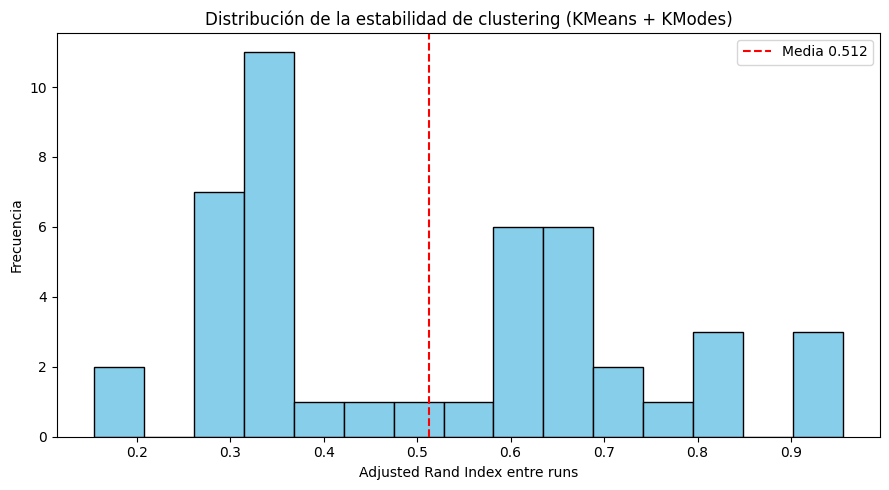


Análisis de estabilidad completado!


In [35]:
# Celda 57 - ANÁLISIS DE ESTABILIDAD CON BOOTSTRAPPING (adaptada a KMeans + KModes)

import numpy as np
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
from tqdm import tqdm

print("="*80)
print("ANÁLISIS DE ESTABILIDAD CON BOOTSTRAPPING - KMEANS + KMODES")
print("="*80)

# Configuración
K = optimal_k
n_runs = 10
sample_frac = 0.8

# Datos completos (usar variables ya definidas en el notebook)
X_num_all = df_numericas.values
X_cat_all = df_categoricas.values
n_samples = len(X_num_all)

print(f"\nConfiguración:")
print(f"  • K: {K}")
print(f"  • Repeticiones: {n_runs}")
print(f"  • Fracción muestra: {sample_frac*100:.0f}% (~{int(sample_frac * n_samples):,} registros)")
print(f"  • Datos numéricos: {X_num_all.shape}")
print(f"  • Datos categóricos: {X_cat_all.shape}")

# Guardar combinaciones de labels como strings (por run)
all_combined_str = []

rng = np.random.default_rng(2025)
print(f"\nEjecutando {n_runs} repeticiones con bootstrapping...")

for i in tqdm(range(n_runs), desc="Bootstrapping"):
    # indices bootstrap (sin reemplazo)
    idx = rng.choice(n_samples, size=int(sample_frac * n_samples), replace=False)
    
    X_num_boot = X_num_all[idx]
    X_cat_boot = X_cat_all[idx]
    
    # Entrenar KMeans (en muestra bootstrap)
    kmeans_boot = KMeans(
        n_clusters=K,
        n_init=1,
        max_iter=30,
        random_state=None,
        verbose=0
    )
    kmeans_boot.fit(X_num_boot)
    
    # Entrenar KModes (en muestra bootstrap)
    kmodes_boot = KModes(
        n_clusters=K,
        init='Huang',
        n_init=1,
        verbose=0,
        random_state=None
    )
    kmodes_boot.fit(X_cat_boot)
    
    # Predecir en TODOS los datos
    labels_km = kmeans_boot.predict(X_num_all)
    labels_kmo = kmodes_boot.predict(X_cat_all)
    
    # Combinar etiquetas como en el pipeline principal
    combined = [f"{a}_{b}" for a, b in zip(labels_km, labels_kmo)]
    all_combined_str.append(combined)

print("Bootstrapping completado!")

# Unificar clases y codificar numéricamente para comparar
all_unique = np.unique([item for run in all_combined_str for item in run])
le_boot = LabelEncoder().fit(all_unique)

all_labels = np.zeros((n_runs, n_samples), dtype=int)
for i, run in enumerate(all_combined_str):
    all_labels[i, :] = le_boot.transform(run)

# Calcular estabilidad (ARI entre todas las parejas)
print("\nCalculando estabilidad...")
stabilities = []
for i in tqdm(range(n_runs), desc="Calculando ARI"):
    for j in range(i+1, n_runs):
        stabilities.append(adjusted_rand_score(all_labels[i, :], all_labels[j, :]))

mean_stability = np.mean(stabilities)
std_stability = np.std(stabilities)

print(f"\nResultados de Estabilidad:")
print(f"  • Stability (mean ARI): {mean_stability:.3f}")
print(f"  • Desviación estándar: {std_stability:.3f}")
print(f"  • ARI mínimo: {min(stabilities):.3f}")
print(f"  • ARI máximo: {max(stabilities):.3f}")

# Visualización
plt.figure(figsize=(9,5))
plt.hist(stabilities, bins=15, color='skyblue', edgecolor='black')
plt.axvline(mean_stability, color='red', linestyle='--', label=f'Media {mean_stability:.3f}')
plt.xlabel("Adjusted Rand Index entre runs")
plt.ylabel("Frecuencia")
plt.title("Distribución de la estabilidad de clustering (KMeans + KModes)")
plt.legend()
plt.tight_layout()
plt.show()

print("\nAnálisis de estabilidad completado!")


Matriz de confusión:
        Pred 0  Pred 1  Pred 2  Pred 3  Pred 4  Pred 5  Pred 6  Pred 7  Pred 8
Real 0   14617     108      26     331       1       0       0       0       0
Real 1      18   16418     129       0     246       4       0       0       0
Real 2      86      17   11258       3       0     185       0       0       1
Real 3     450       4       1    6735      98      42       0       0       0
Real 4       0     412       4       8    5602      46       0       0       0
Real 5       1       1     232      43       7    4572       0       0       0
Real 6       1       2       0       0       0       0      56      23       2
Real 7       3       1       0       0       0       0      13      84       1
Real 8       0       1       5       0       0       0       6       6      44

Accuracy: 0.9585    Adjusted Rand Index: 0.9140

Reporte de clasificación:
              precision    recall  f1-score   support

   Cluster 0       0.96      0.97      0.97     15083
   

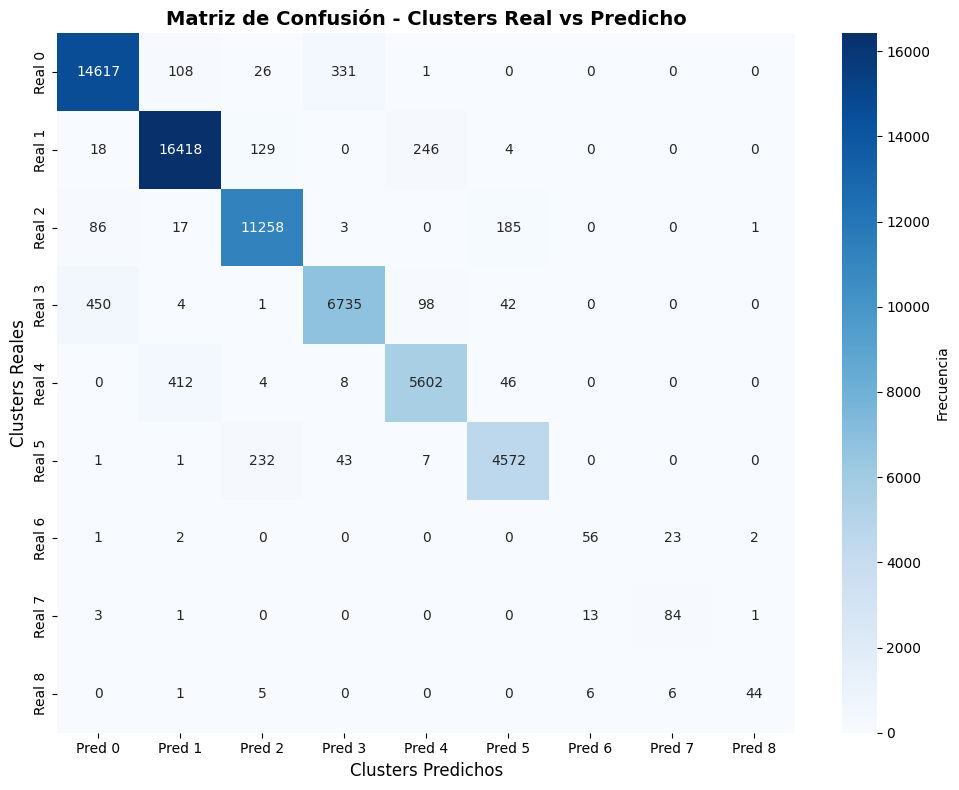

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, adjusted_rand_score, classification_report

# Seleccionar y_true e y_pred según variables presentes
if 'x_test' in globals() and 'y_predict_knn' in globals():
    y_true = x_test['Clusters_modelo'].to_numpy()
    y_pred = y_predict_knn
else:
    y_true = globals().get('clusters_combined_test_num', None)
    y_pred = globals().get('y_pred', None)

if y_true is None or y_pred is None:
    raise NameError("No se encontraron variables para y_true/y_pred. Use 'x_test' & 'y_predict_knn' o 'clusters_combined_test_num' & 'y_pred'.")

# Etiquetas ordenadas (maneja valores no consecutivos)
labels = np.unique(np.concatenate([np.asarray(y_true), np.asarray(y_pred)]))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=[f'Real {l}' for l in labels], columns=[f'Pred {l}' for l in labels])

print("\nMatriz de confusión:")
print(cm_df)

# Métricas principales
acc = accuracy_score(y_true, y_pred)
ari = adjusted_rand_score(y_true, y_pred)
print(f"\nAccuracy: {acc:.4f}    Adjusted Rand Index: {ari:.4f}\n")

# Reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y_true, y_pred, labels=labels, target_names=[f'Cluster {l}' for l in labels]))

# Visualización
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Pred {l}' for l in labels],
            yticklabels=[f'Real {l}' for l in labels],
            cbar_kws={'label': 'Frecuencia'})
plt.title('Matriz de Confusión - Clusters Real vs Predicho', fontsize=14, fontweight='bold')
plt.ylabel('Clusters Reales', fontsize=12)
plt.xlabel('Clusters Predichos', fontsize=12)
plt.tight_layout()
plt.show()

In [37]:
# ...existing code...
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# Asegurarse de tener y_true y y_pred definidos
labels = np.unique(np.concatenate([np.asarray(y_true), np.asarray(y_pred)]))
target_names = [f'Cluster {l}' for l in labels]

# Imprimir reporte clásico
print("Classification Report:\n")
print(classification_report(y_true, y_pred, labels=labels, target_names=target_names))

# Opcional: mostrar como DataFrame para revisión y exportación
report_dict = classification_report(y_true, y_pred, labels=labels, target_names=target_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().round(4)
print("\nClassification Report (DataFrame):")
display(report_df)

Classification Report:

              precision    recall  f1-score   support

   Cluster 0       0.96      0.97      0.97     15083
   Cluster 1       0.97      0.98      0.97     16815
   Cluster 2       0.97      0.97      0.97     11550
   Cluster 3       0.95      0.92      0.93      7330
   Cluster 4       0.94      0.92      0.93      6072
   Cluster 5       0.94      0.94      0.94      4856
   Cluster 6       0.75      0.67      0.70        84
   Cluster 7       0.74      0.82      0.78       102
   Cluster 8       0.92      0.71      0.80        62

    accuracy                           0.96     61954
   macro avg       0.90      0.88      0.89     61954
weighted avg       0.96      0.96      0.96     61954


Classification Report (DataFrame):


,precision,recall,f1-score,support
Cluster 0,0.9632,0.9691,0.9661,15083.0000
Cluster 1,0.9678,0.9764,0.9721,16815.0000
Cluster 2,0.9659,0.9747,0.9703,11550.0000
Cluster 3,0.9459,0.9188,0.9322,7330.0000
Cluster 4,0.9409,0.9226,0.9316,6072.0000
Cluster 5,0.9429,0.9415,0.9422,4856.0000
Cluster 6,0.7467,0.6667,0.7044,84.0000
Cluster 7,0.7434,0.8235,0.7814,102.0000
Cluster 8,0.9167,0.7097,0.8000,62.0000
accuracy,0.9585,0.9585,0.9585,0.9585
